# Analysis of correction activations

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.special import binom
from sklearn.cluster import KMeans
from tqdm import tqdm
import rasterio
from joblib import dump, load
from itertools import combinations
import random

In [4]:
project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
print(project_dir)

/home/tanguyen/Documents/Projects/2020/ForestMapping/Code/ForestMapping


## Sampling, clustering and plotting functions

In [5]:
forest_colormap = [(21/255, 180/255, 0/255, 1),     #OF
                (25/255, 90/255, 0/255, 1),         #CF
                (151/255, 169/255, 93/255, 1),      #SF
                (7/255, 153/255, 146/255, 1)]        #F
colormap = np.array(['goldenrod', 'crimson', 'darkorchid'])
n_val_per_im = 200
band_names = ['OF', 'CF', 'SF', 'F']
cluster_lim = 10
subset=2000
NODATA_VAL = np.finfo(np.float32).max

colormap_dict = {}
for c in colormap:
    colormap_dict[c] = tuple([int(x * 255) for x in colors.to_rgba(c)])
    
def sample_correction_values(dir, n_val_per_im = 100):
    prefix = 'corr_activations'
    n_val_per_im = int(n_val_per_im)

    values = []
    for basename in tqdm(os.listdir(dir)):
        if os.path.splitext(basename)[-1] == '.tif':
            if basename.startswith(prefix):
                fn = os.path.join(dir, basename)
                with rasterio.open(fn, 'r') as f:
                    im = f.read()
                im = im.reshape(im.shape[0], -1)
                idx = random.sample(range(im.shape[-1]), n_val_per_im)
                samples = im[:,idx]
                samples = samples[:,np.all(samples!=NODATA_VAL, axis=0)]
                values.append(samples)
                
    values_arr = np.concatenate(values, axis=-1)
    np.save(os.path.join(dir,'corr_samples_{}_val_per_im'.format(n_val_per_im)), values_arr)
    
    return values_arr

def get_values(dir, n_val_per_im, sample_new = False):
    if sample_new:
        # sample new values
        v = sample_correction_values(dir, n_val_per_im=n_val_per_im)
    else:
        # or load previously saved values
        fn = os.path.join(dir,'corr_samples_{}_val_per_im.npy'.format(n_val_per_im))
        v = np.load(fn)
    return v

def plot_histograms(v, colormap, p=0.1, xlim=None, ylim=1):
    if xlim is None:
        xlim = max(abs(np.percentile(v, 100-p)), abs(np.percentile(v, p)))
    fig = plt.figure(figsize=(10,2.5))
    subplot_param = 100 + 10 * v.shape[0] + 1
    for b in range(v.shape[0]):
        ax = fig.add_subplot(subplot_param + b) 
        h = plt.hist(v[b], bins = 200, range=(-xlim, xlim), density=True, color=colormap[b])
        ax.set_title(band_names[b])
        ax.set_xlim(-xlim, xlim)
        ax.set_ylim(0, ylim)
        ax.grid()
        ax.set_xlabel('correction activation')
        if b == 0:
            ax.set_ylabel('density')
    plt.tight_layout()
    plt.show()
    
def plot_clusters(v, y_pred, dim_names, p=0.1, xlim=None, ylim=None, subset=None, colormap=colormap):
    if subset is not None:
        idx = random.sample(range(0, v.shape[1]), subset)
        v = v[:, idx]
        y_pred = y_pred[idx]
    n_dims = v.shape[0]
    n_subplots = int(binom(n_dims, 2))
    size = 2
    fig = plt.figure(figsize=(int(size*n_subplots)+2, size))
    subplot_param = 100 + 10 * n_subplots + 1
    plot_idx = 0
    for i in range(n_dims):
        for j in range(i+1, n_dims):
            if xlim is None:
                xlim = max(abs(np.percentile(v[i], p)), abs(np.percentile(v[i], 100-p)))
            if ylim is None:
                ylim = max(abs(np.percentile(v[j], p)), abs(np.percentile(v[j], 100-p)))
            ax = fig.add_subplot(subplot_param + plot_idx)
            ax.grid(True)
            markersize=4
            sc = ax.scatter(v[i], v[j], s=markersize**2, alpha=0.1, c=colormap[y_pred])
            ax.set_xlabel(dim_names[i])
            ax.set_ylabel(dim_names[j])
            ax.set_xlim(-xlim, xlim)
            ax.set_ylim(-ylim, ylim)
            ax.set_xticks([-xlim, -xlim/2, 0, xlim/2, xlim])
            ax.set_yticks([-ylim, -ylim/2, 0, ylim/2, ylim])
            plot_idx += 1
            if plot_idx == n_subplots:
                h = lambda c: plt.Line2D([],[],color=c, ls="",marker="o", markersize=markersize)
                cats = np.unique(y_pred)
                lgnd = ax.legend(handles=[h(colormap[cat]) for cat in cats], 
                                 labels=['cluster {}'.format(cat) for cat in cats],
                                 loc='center left', bbox_to_anchor=(1, 0.5)
                                 )
                for lh in lgnd.legendHandles: 
                    lh.set_alpha(0.5)
                    
    plt.tight_layout()
    plt.show()
    
def cluster(v, n_clusters=3, p=0.1, cluster_new=True, dir=None):
    min_v = np.percentile(v, p, axis=1)
    max_v = np.percentile(v, 100-p, axis=1)
    mask = np.all((v.T > min_v) * (v.T < max_v), axis=1)
    valid_vals = v[:, mask]
    fn = os.path.join(dir,'corr_kmeans_{}_clusters.joblib'.format(n_clusters))
    if cluster_new:
        kmeans = KMeans(n_clusters=n_clusters)
        y_pred = kmeans.fit_predict(valid_vals.T)
        dump(kmeans, fn)
    else:
        kmeans = load(fn)
        y_pred = kmeans.predict(valid_vals.T)
    for c in range(n_clusters):
        m = np.mean(valid_vals.T[y_pred==c], axis=0)
        print('Mean of {}th cluster: {}'.format(c, m))
        print('Proportion of samples: {}'.format(np.sum(y_pred==c)/y_pred.size))
    return y_pred, kmeans, valid_vals

def plot_3D_clusters(v, y_pred, dim_names, p=0.1, xlim=None, ylim=None, zlim=None, subset=None, select_axis=None, markersize=2, colormap=colormap):
    if subset is not None:
        idx = random.sample(range(0, v.shape[1]), subset)
        v = v[:, idx]
        y_pred = y_pred[idx]
    n_dims = v.shape[0]
    comb = list(combinations(range(n_dims), 3))
    if select_axis is not None:
        comb = [x for x, b in zip(comb, select_axis) if b]
    n_subplots = len(comb)
    size = 3
    fig = plt.figure(figsize=(int(size*(n_subplots+1)), size))
    subplot_param = 100 + 10 * n_subplots + 1
    for plot_idx, dims in enumerate(comb):
        i, j, k = dims
        if xlim is None:
            xlim = max(abs(np.percentile(v[i], p)), abs(np.percentile(v[i], 100-p)))
        if ylim is None:
            ylim = max(abs(np.percentile(v[j], p)), abs(np.percentile(v[j], 100-p)))
        if zlim is None:
            zlim = max(abs(np.percentile(v[k], p)), abs(np.percentile(v[k], 100-p)))
        ax = fig.add_subplot(subplot_param + plot_idx, projection='3d')
        ax.grid(True)
        
        x_start, y_start, z_start = np.array([[-xlim,0,0],[0,-ylim,0],[0,0,-zlim]])
        x_end, y_end, z_end = np.array([[2*xlim,0,0],[0,2*ylim,0],[0,0,2*zlim]])
        ax.quiver(x_start,y_start,z_start,x_end,y_end,z_end,arrow_length_ratio=0.1, color="black", alpha=0.5)
        
        colors = colormap[y_pred]
        ax.scatter(v[i], v[j], v[k], s=markersize**2, c=colors, alpha=0.5)
        
        ax.set_xlabel(dim_names[i])
        ax.set_ylabel(dim_names[j])
        ax.set_zlabel(dim_names[k])
        ax.set_xlim(-xlim, xlim)
        ax.set_ylim(-ylim, ylim)
        ax.set_zlim(-zlim, zlim)
        ax.set_xticks([-xlim, -xlim/2, 0, xlim/2, xlim])
        ax.set_yticks([-ylim, -ylim/2, 0, ylim/2, ylim])
        ax.set_zticks([-zlim, -zlim/2, 0, zlim/2, zlim])
        ax.view_init(elev=30, azim=30)
        
        if plot_idx == n_subplots-1:
            h = lambda c: plt.Line2D([],[],color=c, ls="",marker="o", markersize=markersize)
            cats = np.unique(y_pred)
            lgnd = ax.legend(handles=[h(colormap[cat]) for cat in cats], 
                                labels=['cluster {}'.format(cat+1) for cat in cats],
                                loc='center left', bbox_to_anchor=(1, 0.5)
                                )
            for lh in lgnd.legendHandles: 
                lh.set_alpha(1)
    plt.tight_layout()
    plt.show()
    
def write_clustered_tiles(kmeans, dir, colormap_dict):
    # create images with cluster values
    prefix = 'corr_activations'
    for basename in tqdm(os.listdir(dir)):
        if os.path.splitext(basename)[-1] == '.tif':
            if basename.startswith(prefix):
                fn = os.path.join(dir, basename)
                with rasterio.open(fn, 'r') as f:
                    im = f.read()
                    profile = f.profile
                profile['count'] = 1
                profile['dtype'] = 'uint8'
                n_bands, h, w = im.shape
                im_out_flat = kmeans.predict(im.reshape(n_bands, -1).T) + 1
                im_out = im_out_flat.reshape(h, w)
                fn_out = fn.replace(prefix, 'corr_clusters')
                with rasterio.open(fn_out, 'w', **profile) as f_out:
                    f_out.write(im_out.astype(np.uint8), 1)
                    f_out.write_colormap(1, colormap_dict)

## sb_hierarchical_MSElog1em1_MSE_doubling_negatives

In [6]:
dir = os.path.join(project_dir, 'output/sb_hierarchical_MSElog1em1_MSE_doubling_negatives/inference/epoch_19/test')
v = get_values(dir, n_val_per_im, sample_new = False)

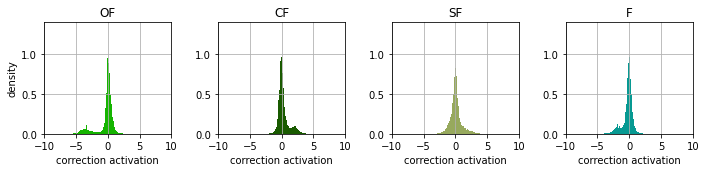

In [731]:
plot_histograms(v, colormap=forest_colormap, xlim=10, ylim=1.4)

Mean of 0th cluster: [ 0.13362758  0.02234461 -0.1559713   0.00435202]
Proportion of samples: 0.8610756481975813
Mean of 1th cluster: [-3.3759284  1.8957994  1.4801362 -1.7542369]
Proportion of samples: 0.1389243518024187


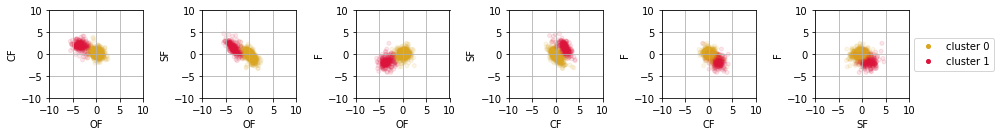

In [34]:
n_clusters = 2
y_pred, kmeans, valid_vals = cluster(v, n_clusters=n_clusters, cluster_new=False, dir=dir)
plot_clusters(valid_vals, y_pred, dim_names=band_names, xlim=cluster_lim, ylim=cluster_lim, subset=subset)

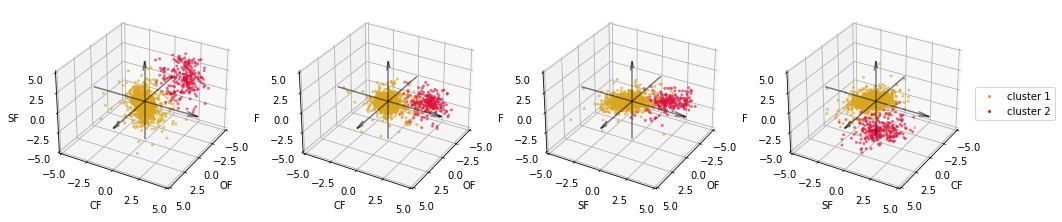

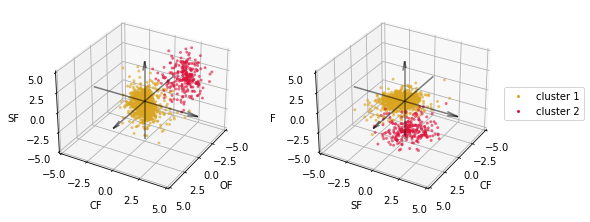

In [35]:
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset)
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset, select_axis=[True, False, False, True])

In [31]:
write_clustered_tiles(kmeans, dir, colormap_dict)

100%|██████████| 2023/2023 [01:24<00:00, 23.86it/s]


## sb_hierarchical_MSElog1em1_MSE_doubling_negatives_eps_2em1

In [36]:
dir = os.path.join(project_dir, 'output/sb_hierarchical_MSElog1em1_MSE_doubling_negatives_eps_2em1/inference/epoch_19/test')
v = get_values(dir, n_val_per_im, sample_new = False)

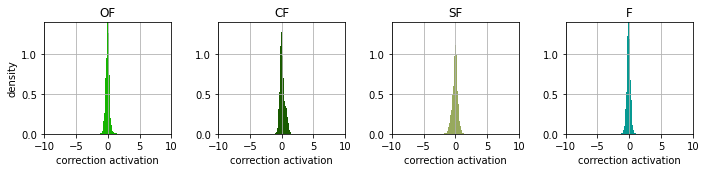

In [735]:
plot_histograms(v, colormap=forest_colormap, xlim=10, ylim=1.4)

Mean of 0th cluster: [-0.04370022  0.12444257 -0.08074242 -0.08844072]
Proportion of samples: 1.0


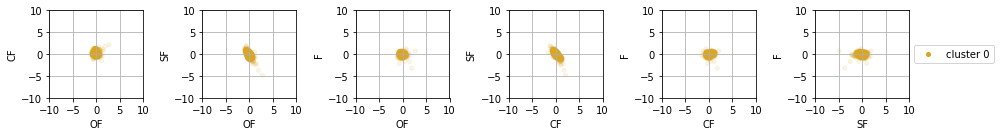

In [37]:
n_clusters = 1
y_pred, kmeans, valid_vals = cluster(v, n_clusters=n_clusters, cluster_new=False, dir=dir)
plot_clusters(valid_vals, y_pred, dim_names=band_names, xlim=cluster_lim, ylim=cluster_lim, subset=subset)

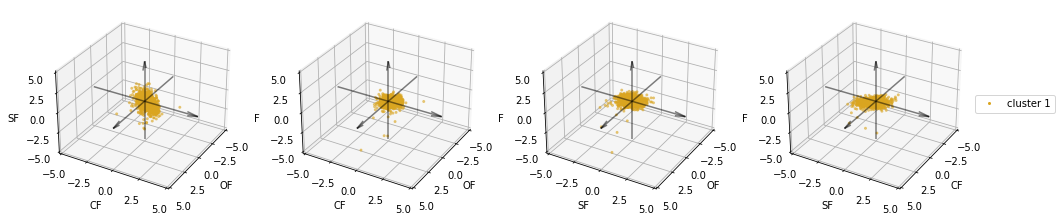

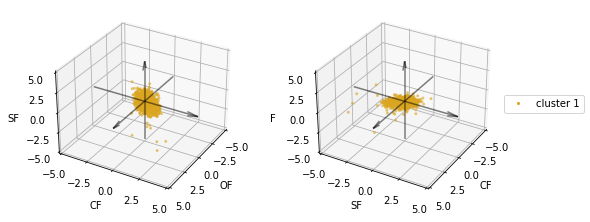

In [38]:
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset)
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset, select_axis=[True, False, False, True])

In [ ]:
write_clustered_tiles(kmeans, dir, colormap_dict)

## sb_hierarchical_MSElog1em1_MSE_doubling_negatives_lpen_2em1

In [39]:
dir = os.path.join(project_dir, 'output/sb_hierarchical_MSElog1em1_MSE_doubling_negatives_lpen_2em1/inference/epoch_19/test')
v = get_values(dir, n_val_per_im, sample_new = False)

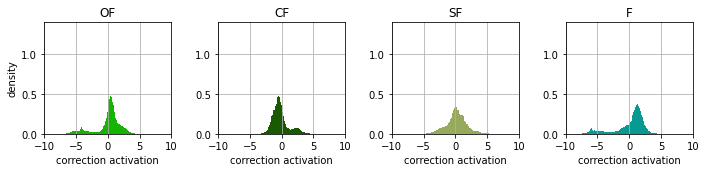

In [739]:
plot_histograms(v, colormap=forest_colormap, xlim=10, ylim=1.4)

Mean of 0th cluster: [ 0.38664526 -0.79460627  0.4079619   1.3603292 ]
Proportion of samples: 0.6601933494586679
Mean of 1th cluster: [-3.9262464  2.0371177  1.889141  -4.836186 ]
Proportion of samples: 0.149888333346213
Mean of 2th cluster: [ 2.1620104   0.08982664 -2.2518432  -0.45248565]
Proportion of samples: 0.18991831719511912


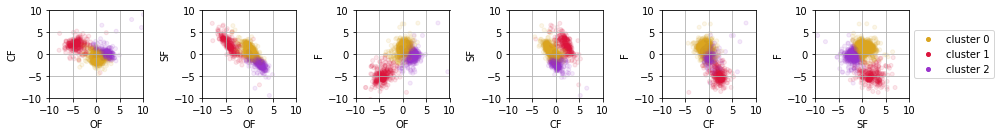

In [41]:
n_clusters = 3
y_pred, kmeans, valid_vals = cluster(v, n_clusters=n_clusters, cluster_new=False, dir=dir)
plot_clusters(valid_vals, y_pred, dim_names=band_names, xlim=cluster_lim, ylim=cluster_lim, subset=subset)

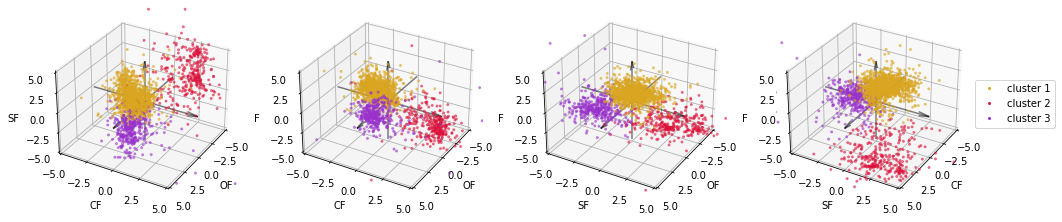

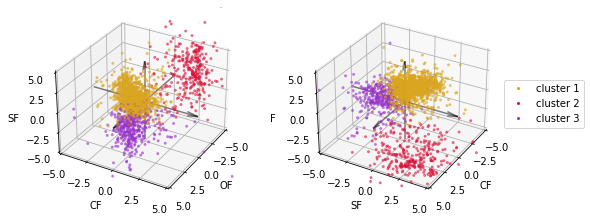

In [42]:
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset, colormap=colormap)
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset, select_axis=[True, False, False, True], colormap=colormap)

In [ ]:
write_clustered_tiles(kmeans, dir, colormap_dict)